# Comparing Models/Approaches

This notebook goes through some examples of ways to compare different models and approaches to matching. To run the comparison notebook, it loads a true label file and prediction files, and walks through some table and plotting comparisons.

## Preparation and Loading

The following cells load libraries, the dataset labels and files with predictions on the same dataset.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.metrics import accuracy_score

### Loading Labels and Predictions
First we load the true label file for analyzing predictions. This file should correspond a MARC-in-JSON dataset used by a model to record predictions.  Contents include (id1,id2,label).

Next we load the prediction files which show the predictions made after comparing two records in the same MARC-in-JSON dataset as the label file above. Contents include (id1,id2,prediction). In addition to model prediction files, we included two non-model approaches, "Fuzzy" and "Exact". 

The default for label/prediction analysis the test set for the Goldfinch 1.1 dataset.

Note: Exact Match and Fuzzy Match used 100$a, 110$a, 111$a, 245$a$b$c$p, 260$b, along with 008 pub place and date, and largest number extracted out from physical description. All text went through normalization of case, punctuation, and diacritics. Exact Match required a perfect match on all fields. Fuzzy match is the average of all similarity metrics (title:token_set, author:token_sort, publisher:token_sort) and 0 or 1 for matching place, date, largest physical description number. These were simple implementations for example only.

In [2]:
# load labels for id1-id2 pairs, with 0 and 1 indicating whether the records are matches or mismatches
labels_file = "../datasets/ht/202303_goldfinch_1.1/202303_goldfinch_set_1.1_test_labels.csv"

# load predictions from list of files (should include all id pairs in labels_file)
predictions_files = [("Goldfinch Model","../results/ht/202303_goldfinch_1.1/20230327_cdl_goldfinch_model/20230327_cdl_goldfinch_predictions_test.csv"),
                      ("Dodo Model","../results/ht/202303_goldfinch_1.1/2022_dodo_model/2022_dodo-goldfinch_predictions_test.csv"),
                      ("Fuzzy Match", "../results/ht/202303_goldfinch_1.1/fuzzy_match_most_fields.csv"),
                      ("Exact Match", "../results/ht/202303_goldfinch_1.1/exact_match_most_fields.csv"),]

In [3]:
# load  labels for file
labels_df = pd.read_csv(labels_file)
# combine id1 and id2 to create pair_id
labels_df["pair_id"] = labels_df["id1"].astype(str) + "_" + labels_df["id2"].astype(str)
# set pair_id as index
analysis_df = labels_df.set_index("pair_id").copy()

# concat prediction files column "prediction" to test_labels_df, only keep prediction column
MODEL_NAMES = {}
for predictions in predictions_files:
    model_name = predictions[0]
    # create shorthand name (all capitals and any numbers)
    model_key = 'pred_' + "".join([char.lower() for char in model_name if char.isupper() or char.isdigit()])
    if model_key in MODEL_NAMES:
        raise Exception("Model key {} already exists for model {}. Create unique model names".format(model_key, MODEL_NAMES[model_key]))
    MODEL_NAMES[model_key] = model_name
    file = predictions[1]
    predictions_df = pd.read_csv(file)
    # combine id1 and id2 to create pair_id
    predictions_df["pair_id"] = predictions_df["id1"].astype(str) + "_" + predictions_df["id2"].astype(str)
    predictions_df = predictions_df.set_index("pair_id")
    # rename prediction column to include model name
    predictions_df = predictions_df.rename(columns={"prediction": model_key})
    # drop all rows not in the label column
    predictions_df = predictions_df.loc[analysis_df.index]
    # only concat prediction column
    analysis_df = pd.concat([analysis_df, predictions_df[model_key]], axis=1)
    print("Loaded {}:{} predictions from {}".format(model_key, model_name, file))

Loaded pred_gm:Goldfinch Model predictions from ../results/ht/202303_goldfinch_1.1/20230327_cdl_goldfinch_model/20230327_cdl_goldfinch_predictions_test.csv
Loaded pred_dm:Dodo Model predictions from ../results/ht/202303_goldfinch_1.1/2022_dodo_model/2022_dodo-goldfinch_predictions_test.csv
Loaded pred_fm:Fuzzy Match predictions from ../results/ht/202303_goldfinch_1.1/fuzzy_match_most_fields.csv
Loaded pred_em:Exact Match predictions from ../results/ht/202303_goldfinch_1.1/exact_match_most_fields.csv


#### Analysis Dataframe
We have no created an analysis dataframe for all our comparisons. We print out hte first 5 rows from the dataframe. The models each have their own prediction columns, prefixed by 'pred_'.

In [4]:
# print key, value for each model in MODEL_NAMES
print("Models in dataframe:")
for key, value in MODEL_NAMES.items():
    print(key+':', value)
analysis_df.head(5)

Models in dataframe:
pred_gm: Goldfinch Model
pred_dm: Dodo Model
pred_fm: Fuzzy Match
pred_em: Exact Match


,id1,id2,label,pred_gm,pred_dm,pred_fm,pred_em
pair_id,,,,,,,
id.19e9fa51d7_id.0ef978caff,id.19e9fa51d7,id.0ef978caff,1,0.999207,9.999298e-01,0.771667,0.0
id.1b8daff53e_id.868dc615aa,id.1b8daff53e,id.868dc615aa,0,0.000254,2.545113e-05,0.598333,0.0
id.f4eabb2891_id.78f8c51e47,id.f4eabb2891,id.78f8c51e47,0,0.000237,1.143519e-09,0.118333,0.0
id.7c36ff0189_id.17b796c796,id.7c36ff0189,id.17b796c796,0,0.000291,2.697709e-06,0.561667,0.0
id.be3d7a8a29_id.90e5364c12,id.be3d7a8a29,id.90e5364c12,0,0.000400,3.061150e-09,0.116667,0.0


## Analysis

### Confusion Matrix
Confusion matrices will let you compare the types of mistakes made in a model, whether it is matching two records about different things (false positive), or it is not matching two records about the same thing (false negative). "False" indicates the classification is the opposite of what it should be. Positive and negative refer to the binary classification of a match (positive) or a mismatch (negative). So a false positive is something the model called a match which is actually a mismatch. 

Confusion Matrix: https://towardsdatascience.com/understanding-confusion-matrix-a9ad42dcfd62

The next cell creates a method for plotting two matrices side-by-side.

In [5]:
def plot_confusion_matrices(df, threshold, two_models=None):
    # if no two models given, use first two models
    if two_models is None:
        select_models = [col for col in df.columns if col.startswith("pred_")][:2]
        two_models = {k: v for k, v in MODEL_NAMES.items() if k in select_models}
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))

    for idx, column in enumerate([col for col in df.columns if col in two_models]):
        # Create confusion matrix
        cm = confusion_matrix(df["label"], df[column].apply(lambda x: 1 if x >= threshold else 0))

        # Calculate accuracy
        accuracy = (cm[0, 0] + cm[1, 1]) / cm.sum()

        # Plot confusion matrix
        ax = axes[idx]
        im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
        ax.figure.colorbar(im, ax=ax)
        ax.grid(False)  # Remove the grid lines within each confusion box

        # Set ticks and labels
        ax.set(xticks=np.arange(cm.shape[1]),
               yticks=np.arange(cm.shape[0]),
               xticklabels=["negative", "positive"], yticklabels=["negative", "positive"],
               title=f'Confusion Matrix for {two_models[column]} ({column})\nThreshold: {threshold:.2f}  Accuracy: {accuracy:.4f}',
               ylabel='True label',
               xlabel='Predicted label')

        # Rotate tick labels and set their alignment
        plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

        # Loop over data dimensions and create text annotations
        fmt = 'd'
        thresh = cm.max() / 2.
        for i in range(cm.shape[0]):
            for j in range(cm.shape[1]):
                ax.text(j, i, format(cm[i, j], fmt),
                        ha="center", va="center",
                        color="white" if cm[i, j] > thresh else "black")

    fig.tight_layout()
    plt.show()

# create method to calculate confusion matrix at a given threshold, returns an list of dicts for each pred_ column
# includes tp, tn, fp, fn, accuracy, precision, recall, f1, mcc
def calc_confusion_matrix(df, threshold):
    confusion_matrix = []
    for column in df.columns:
        if column.startswith("pred_"):
            # create confusion matrix
            tp = df[(df[column] >= threshold) & (df["label"] == 1)].shape[0]
            tn = df[(df[column] < threshold) & (df["label"] == 0)].shape[0]
            fp = df[(df[column] >= threshold) & (df["label"] == 0)].shape[0]
            fn = df[(df[column] < threshold) & (df["label"] == 1)].shape[0]
            # calculate accuracy, precision, recall, f1, mcc
            accuracy = (tp + tn) / (tp + tn + fp + fn)
            precision = tp / (tp + fp)
            recall = tp / (tp + fn)
            specificity = tn / (tn + fp)
            f1 = 2 * (precision * recall) / (precision + recall)
            mcc = (tp * tn - fp * fn) / ((tp + fp) * (tp + fn) * (tn + fp) * (tn + fn)) ** 0.5
            # append to confusion matrix
            confusion_matrix.append({"model": column,
                                     "tp": tp,
                                     "tn": tn,
                                     "fp": fp,
                                     "fn": fn,
                                     "accuracy": accuracy,
                                     "precision": precision,
                                     "recall": recall,
                                     "sensitivity": recall,
                                     "specificity": specificity,
                                     "f1": f1,
                                     "mcc": mcc})
    return confusion_matrix

### Comparing GoldFinch and Dodo side-by-side
In the following comparison, we evaluate the accuracy and confusion matrices of two models, Goldfinch and Dodo. The Goldfinch model was trained on the train/validation datasets of the Goldfinch dataset, while the Dodo model was trained on an earlier dataset. Both models were tested using the Goldfinch test set to make predictions.

These models aim to optimize their accuracy around the 50% threshold, which is commonly used for comparison. When a model assesses two MARC records and assigns a prediction/confidence score of 0.5 (50%) or higher, it is considered a match (positive). If the confidence score is below 0.5 (50%), it is deemed a mismatch (negative). We then calculate the accuracy and confusion matrices based on this 50% threshold.

**Result:** Goldfinch has the highest accuracy, so in this comparison would be considered the better classifier. This increase in accuracy is seen mostly in a reduction of false positives compared to Dodo. There are a few more false negatives in Goldfinch.

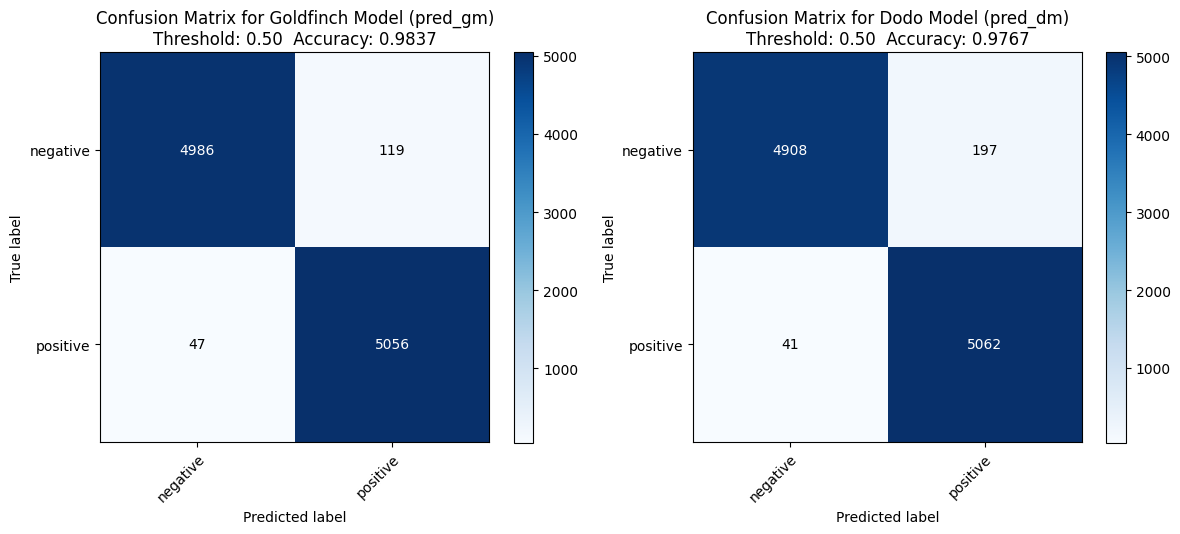

In [6]:
# plot the confusion matrix for each model at a at 0.5
model_1 = "pred_gm"
model_2 = "pred_dm"
two_models = {k: v for k, v in MODEL_NAMES.items() if k in [model_1, model_2]}
plot_confusion_matrices(analysis_df, 0.5, two_models)

### Using a table for comparison
As the number of models to compare increases, using a confusion matrix for comparison becomes challenging. Instead, we can organize these values in a table, which simplifies aligning the values we want to compare. Additionally, we can include other comparative metrics in the table to enhance our analysis. We will include some of these metrics in later analysis. All metrics are in glossary below.

**Result:** Goldfinch continues to be better than model by most metrics.

In [7]:
# when comparing many models, it's easier to compare the confusion matrices in a table
threshold = 0.5
display_df = pd.DataFrame(calc_confusion_matrix(analysis_df,threshold))
print("Models sorted by accuracy at threshold:", threshold, "("+ str(threshold*100) +"%)")
display_df["name"]=display_df["model"].map(MODEL_NAMES)
display_df[['name','tp', 'tn', 'fp', 'fn', 'accuracy', 'precision', 'recall', 'sensitivity', 'specificity', 'f1', 'mcc']].sort_values(by="accuracy", ascending=False)

Models sorted by accuracy at threshold: 0.5 (50.0%)


,name,tp,tn,fp,fn,accuracy,precision,recall,sensitivity,specificity,f1,mcc
0,Goldfinch Model,5056,4986,119,47,0.983738,0.977005,0.990790,0.990790,0.976690,0.983849,0.967573
1,Dodo Model,5062,4908,197,41,0.976685,0.962540,0.991966,0.991966,0.961410,0.977031,0.953816
2,Fuzzy Match,4680,3654,1451,423,0.816418,0.763334,0.917108,0.917108,0.715769,0.833185,0.646091
3,Exact Match,324,5105,0,4779,0.531838,1.000000,0.063492,0.063492,1.000000,0.119403,0.181089


### Thresholds 
In our previous example, we used a 50% threshold to determine matches and mismatches. Confidence values near this threshold are not highly certain but are considered more likely than not to be matches or mismatches, depending on which side they fall. Confidence scores closer to 50% typically correspond to more ambiguous similarities in the comparisons, such as the same government report for different states or different cataloging choices for the same item. These scores are more prone to false positives and false negatives. For instance, a model confidence score of 60% can be interpreted as the model predicting a match 60% of the time and a mismatch 40% of the time.

However, it's essential to recognize that most confidence scores will be either above 99% or below 1% since most cases present clear-cut matches or mismatches. Below we calculate how many values are given a score below 1% and above 99% to show this represents most of the predictions on the test dataset.

In [8]:
# print the percent of predictions for pred_gm that are above 99% threshold or below 1% threshold, without adding a column to the dataframe
model_key = "pred_gm"
high_and_low_confidence_values = analysis_df[model_key].apply(lambda x: 1 if x >= .99 or x <= .01 else 0).sum() / len(analysis_df)
print("Percent of {} predictions above 99% or below 1%: {}".format(MODEL_NAMES[model_key], str(round(high_and_low_confidence_values * 100, 2)) + "%"))

Percent of Goldfinch Model predictions above 99% or below 1%: 89.65%


### Using thresholds to reduce false positives and false negatives
We can increase the threshold to reduce false positives or decrease the false negatives. This is setting the bar for high confidence before considering things are a match, or lowering the confidence before considering things a mismatch. The trade-off is accuracy. However, as the threshold moves up or down to reduce false positives or false negatives, the accuracy of predictions will go down. 

Note: Exact Match is the same as above because it has no threshold. Every prediction is either 0 or 1.


#### High Threshold
**Result (High Threshold):** Goldfinch or Fuzzy Match. Depending on your tolerance for false positives, Fuzzy Match may be preferred. Overall, Goldfinch has has a low number of false positives for the level of accuracy maintained.

In [9]:
threshold = 0.99
display_df = pd.DataFrame(calc_confusion_matrix(analysis_df,threshold))
print("Models sorted by accuracy at threshold:", threshold, "("+ str(threshold*100) +"%)")
display_df["name"]=display_df["model"].map(MODEL_NAMES)
display_df[['name','tp', 'tn', 'fp', 'fn', 'accuracy', 'precision', 'recall', 'sensitivity', 'specificity', 'f1', 'mcc']].sort_values(by="accuracy", ascending=False)

Models sorted by accuracy at threshold: 0.99 (99.0%)


,name,tp,tn,fp,fn,accuracy,precision,recall,sensitivity,specificity,f1,mcc
1,Dodo Model,4985,4994,111,118,0.977567,0.978218,0.976876,0.976876,0.978257,0.977547,0.955134
0,Goldfinch Model,4463,5092,13,640,0.936031,0.997096,0.874584,0.874584,0.997453,0.931830,0.878714
2,Fuzzy Match,959,5104,1,4144,0.593946,0.998958,0.187929,0.187929,0.999804,0.316345,0.321582
3,Exact Match,324,5105,0,4779,0.531838,1.000000,0.063492,0.063492,1.000000,0.119403,0.181089


#### Low Threshold
**Result (Low Threshold):** Goldfinch. Golfinch has the lowest false negatives while maintaining fairly high accuracy. Fuzzy Match does not have symmetrical performance.

In [10]:
threshold = 0.01
display_df = pd.DataFrame(calc_confusion_matrix(analysis_df,threshold))
print("Models sorted by accuracy at threshold:", threshold, "("+ str(threshold*100) +"%)")
display_df["name"]=display_df["model"].map(MODEL_NAMES)
display_df[['name','tp', 'tn', 'fp', 'fn', 'accuracy', 'precision', 'recall', 'sensitivity', 'specificity', 'f1', 'mcc']].sort_values(by="accuracy", ascending=False)

Models sorted by accuracy at threshold: 0.01 (1.0%)


,name,tp,tn,fp,fn,accuracy,precision,recall,sensitivity,specificity,f1,mcc
1,Dodo Model,5090,4750,355,13,0.963950,0.934803,0.997452,0.997452,0.930460,0.965112,0.929991
0,Goldfinch Model,5103,4675,430,0,0.957876,0.922284,1.000000,1.000000,0.915769,0.959571,0.919021
3,Exact Match,324,5105,0,4779,0.531838,1.000000,0.063492,0.063492,1.000000,0.119403,0.181089
2,Fuzzy Match,4714,488,4617,389,0.509600,0.505198,0.923770,0.923770,0.095593,0.653180,0.034548


In [11]:
# Time to remove Exact Match from our analysis. It's predictions have no threshold, they are always 0 or 1.
# Remove pred_em from the analysis_df
if "pred_em" in analysis_df.columns:
  analysis_df = analysis_df.drop(columns=["pred_em"])
  # drop from model_names
  print("Removing ", MODEL_NAMES.pop("pred_em"), "from analysis")


Removing  Exact Match from analysis


### Accuracy by Threshold Curve

Accuracy is rarely plotted by threshold, but this is an interesting plot for two reasons. 

First, you can see Fuzzy Match is not calibrated at the 50% threshold. The approach is only an average of similarity among select fields and therefore it's values don't represent a confidence.

Second, you can see that Goldfinch has better accuracy in the middle (50% threshold), but they accuracy does fall off at the corners compared to Dodo. This is the trade-off for reducing false positives and negatives at those thresholds.

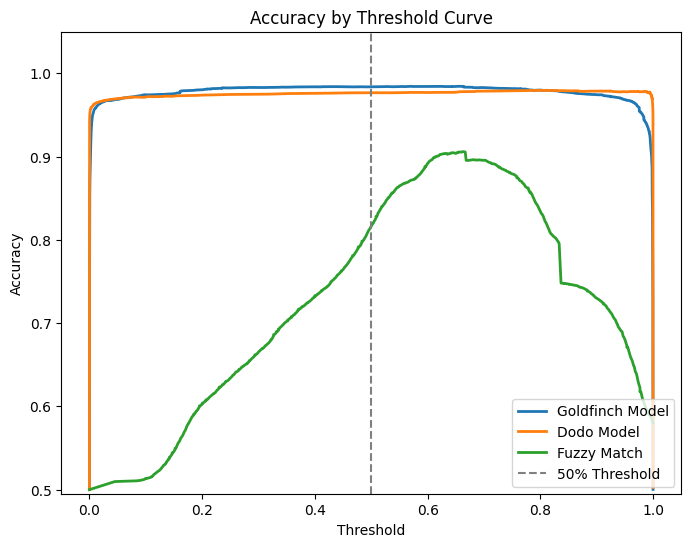

In [12]:
# Function to calculate accuracy for each threshold
def calculate_accuracy_by_threshold(y_true, y_pred_proba, thresholds):
    accuracy_list = []
    for threshold in thresholds:
        y_pred = (y_pred_proba >= threshold).astype(int)
        accuracy = accuracy_score(y_true, y_pred)
        accuracy_list.append(accuracy)
    return accuracy_list

# plot accuracy by threshold curve
fig, ax = plt.subplots(figsize=(8, 6))
for column in analysis_df.columns:
    if column.startswith("pred_"):
        precision, recall, thresholds = precision_recall_curve(analysis_df["label"], analysis_df[column])
        accuracy_list = calculate_accuracy_by_threshold(analysis_df["label"], analysis_df[column], thresholds)
        ax.plot(thresholds, accuracy_list, lw=2, label=MODEL_NAMES[column])
ax.set(xlim=[-0.05, 1.05], ylim=[0.495, 1.05], title="Accuracy by Threshold Curve")
# add axis labels
ax.set_xlabel("Threshold")
ax.set_ylabel("Accuracy")
# Add vertical dashed line at 50% threshold
plt.axvline(x=0.5, color='gray', linestyle='--', label="50% Threshold")

ax.legend(loc="lower right")

plt.show()


### Receiver operating characteristic (ROC)
The receiver operating characteristic (ROC) curve is commonly used in comparisons. This is an curve that plots the rate of false positives on the x-axis, and the rate of true positives is on the y-axis. Ideally, you want the line to hug the y-axis till it hits the top of the chart. The means the method is having good success in finding all the true positives without introducing many false positives. The curved corner of the data indicates the false positive rate increases when trying to identity last 5% of true positives (e.g. the ambiguous cases). Sometimes it requires zooming in to better see the differences between the cures. 

**Result**:Goldfinch demonstrates a better ROC curve, indicating it’s better at finding true positives without as many false positives as Dodo.

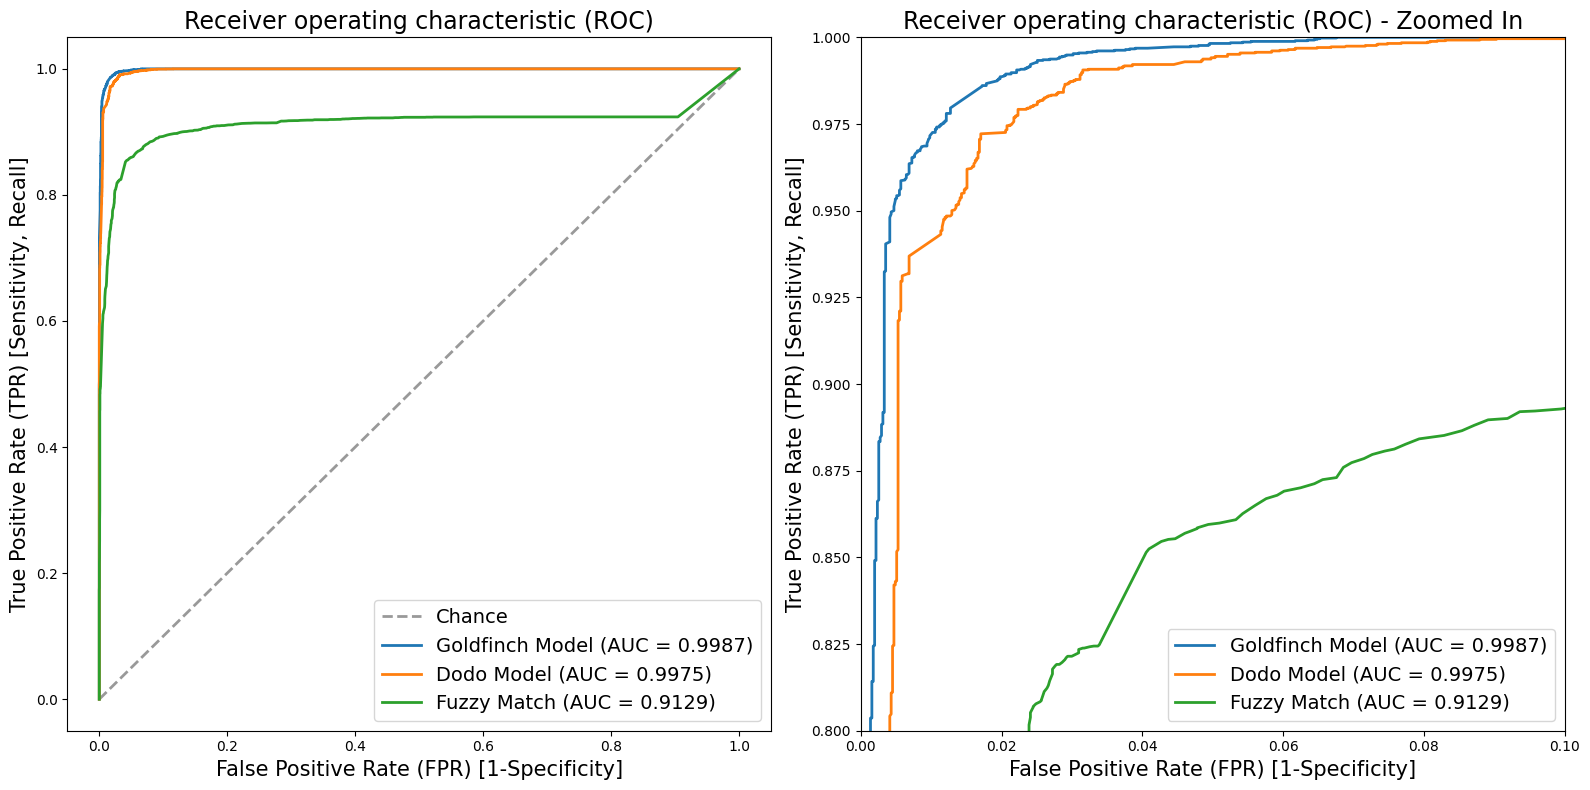

In [13]:
label_font_size = 15
legend_font_size = 14
title_font_size = 17

# Set up the side-by-side subplots
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(16, 8))

# Plot the ROC curve for all models (left subplot)
ax1.plot([0, 1], [0, 1], linestyle='--', lw=2, color='grey', label='Chance', alpha=.8)
for column in analysis_df.columns:
    if column.startswith("pred_"):
        fpr, tpr, thresholds = roc_curve(analysis_df["label"], analysis_df[column])
        roc_auc = auc(fpr, tpr)
        ax1.plot(fpr, tpr, lw=2, label=MODEL_NAMES[column] + ' (AUC = %0.4f)' % (roc_auc))
ax1.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05], title="Receiver operating characteristic (ROC)")
ax1.set_xlabel("False Positive Rate (FPR) [1-Specificity]", fontsize=label_font_size)
ax1.set_ylabel("True Positive Rate (TPR) [Sensitivity, Recall]", fontsize=label_font_size)
ax1.legend(loc="lower right", fontsize=legend_font_size)
ax1.title.set_fontsize(title_font_size)

# Plot the zoomed-in ROC curve (right subplot)
for column in analysis_df.columns:
    if column.startswith("pred_"):
        fpr, tpr, thresholds = roc_curve(analysis_df["label"], analysis_df[column])
        roc_auc = auc(fpr, tpr)
        ax2.plot(fpr, tpr, lw=2, label=MODEL_NAMES[column] + ' (AUC = %0.4f)' % (roc_auc))
ax2.set(xlim=[-0.00, 0.1], ylim=[0.8, 1.00], title="Receiver operating characteristic (ROC) - Zoomed In")
ax2.set_xlabel("False Positive Rate (FPR) [1-Specificity]", fontsize=label_font_size)
ax2.set_ylabel("True Positive Rate (TPR) [Sensitivity, Recall]", fontsize=label_font_size)
ax2.legend(loc="lower right", fontsize=legend_font_size)
ax2.title.set_fontsize(title_font_size)

# Display the side-by-side plots
plt.tight_layout()
plt.show()




### Precision-Recall Curve
Similar to ROC, the Precision-Recall curve plots the interaction between levels of recall and levels of precision. Precision and recall are commonly used metrics for evaluating search performance. Precision calculates the percentage of retrieved items that are actually relevant, while recall metrics the proportion of relevant items in the entire document collection that are retrieved. In this context, recall indicates how many real matches were identified as matches, and precision demonstrates how many items identified as matches were indeed real matches.

In the first plot, as the threshold increases, the number of false positives decreases, leading to a rise in precision. The second plot shows that recall decreases with an increasing threshold, as real matches with confidence scores below the threshold are not captured. The final plot illustrates the trade-off between precision and recall.

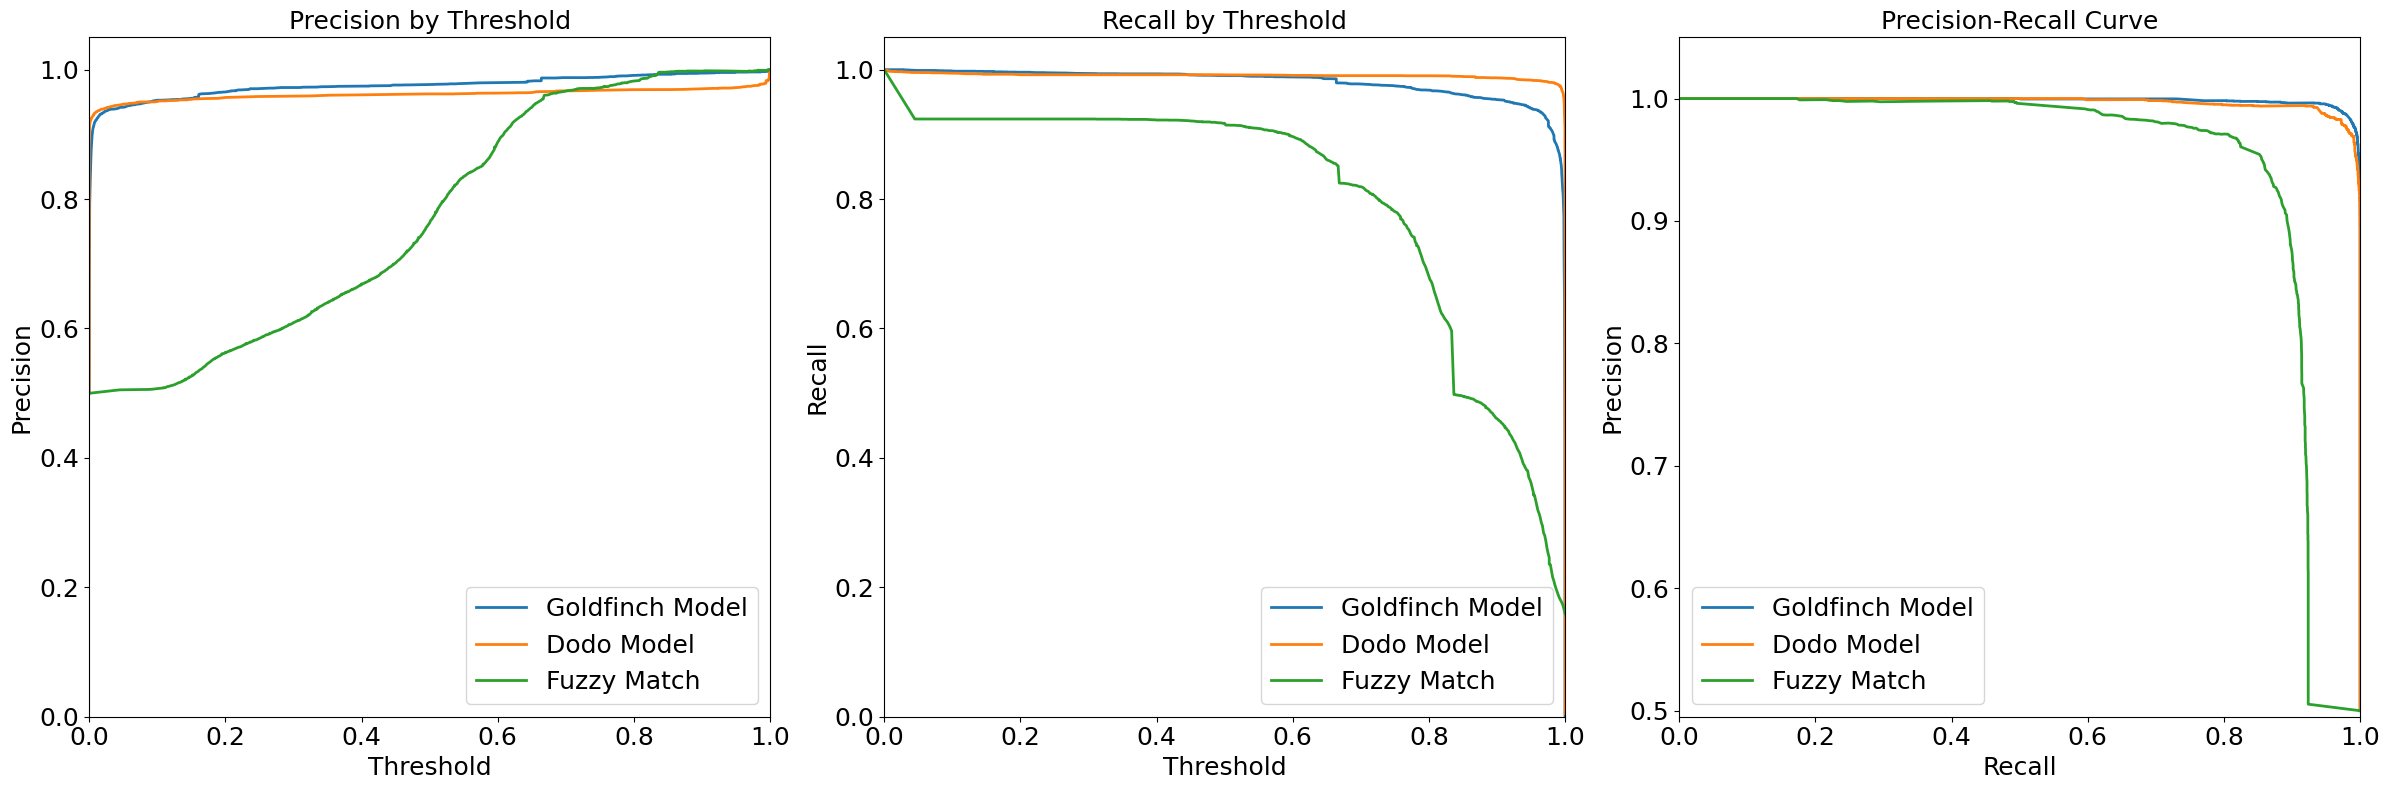

In [14]:
# Create a 1x3 grid of subplots
fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=(24, 8))

# Set font size
font_size = 18

# Plot Precision by Threshold on the first subplot (ax1)
for column in analysis_df.columns:
    if column.startswith("pred_"):
        precision, recall, thresholds = precision_recall_curve(analysis_df["label"], analysis_df[column])
        ax1.plot(thresholds, precision[:-1], lw=2, label=MODEL_NAMES[column])
ax1.set(xlim=[0.0, 1.0], ylim=[0.0, 1.05], title="Precision by Threshold")
ax1.set_xlabel("Threshold", fontsize=font_size)
ax1.set_ylabel("Precision", fontsize=font_size)
ax1.legend(loc="lower right", fontsize=font_size)
ax1.title.set_fontsize(font_size)
ax1.tick_params(axis='both', labelsize=font_size)

# Plot Recall by Threshold on the second subplot (ax2)
for column in analysis_df.columns:
    if column.startswith("pred_"):
        precision, recall, thresholds = precision_recall_curve(analysis_df["label"], analysis_df[column])
        ax2.plot(thresholds, recall[:-1], lw=2, label=MODEL_NAMES[column])
ax2.set(xlim=[0.0, 1.0], ylim=[0.0, 1.05], title="Recall by Threshold")
ax2.set_xlabel("Threshold", fontsize=font_size)
ax2.set_ylabel("Recall", fontsize=font_size)
ax2.legend(loc="lower right", fontsize=font_size)
ax2.title.set_fontsize(font_size)
ax2.tick_params(axis='both', labelsize=font_size)

# Plot Precision-Recall curve on the third subplot (ax3)
for column in analysis_df.columns:
    if column.startswith("pred_"):
        precision, recall, thresholds = precision_recall_curve(analysis_df["label"], analysis_df[column])
        ax3.plot(recall, precision, lw=2, label=MODEL_NAMES[column])
ax3.set(xlim=[0.0, 1.0], ylim=[0.495, 1.05], title="Precision-Recall Curve")
ax3.set_xlabel("Recall", fontsize=font_size)
ax3.set_ylabel("Precision", fontsize=font_size)
ax3.legend(loc="lower left", fontsize=font_size)
ax3.title.set_fontsize(font_size)
ax3.tick_params(axis='both', labelsize=font_size)

# Show the combined plot
plt.tight_layout()
plt.show()


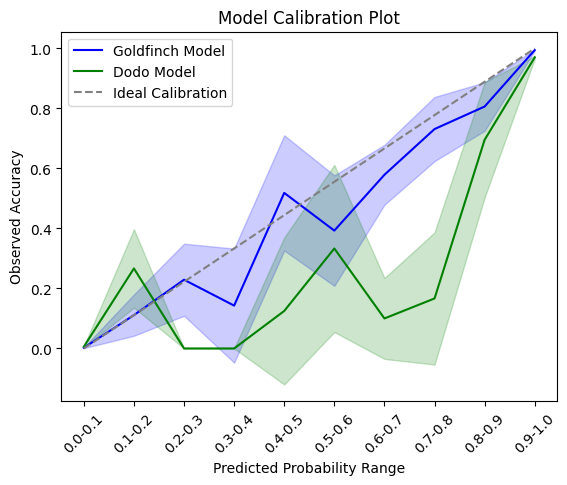

In [15]:
# plot the distribution of the prediction columns for specified models
plot_pred_df = analysis_df.copy()

# Define the category boundaries
categories = np.linspace(0, 1, 11)

# Specify the columns to plot
pred_columns = ['pred_gm', 'pred_dm'] # Replace with the desired column names
colors = ['blue', 'green']

# Initialize the plot
fig, ax = plt.subplots()

for pred_col, color in zip(pred_columns, colors):
    # Group the data by prediction category and compute the accuracy for each group
    plot_pred_df['category'] = pd.cut(plot_pred_df[pred_col], categories)
    accuracy = plot_pred_df.groupby('category')['label'].mean()

    # plot using bins and with confidence intervals
    accuracy = plot_pred_df.groupby('category')['label'].agg(['mean', 'count'])
    accuracy['std'] = plot_pred_df.groupby('category')['label'].std()
    accuracy['std_err'] = accuracy['std'] / np.sqrt(accuracy['count'])
    accuracy['lower'] = accuracy['mean'] - 1.96 * accuracy['std_err']
    accuracy['upper'] = accuracy['mean'] + 1.96 * accuracy['std_err']

    # plot in smooth line graph
    ax.plot(accuracy.index.astype(str), accuracy['mean'], label=MODEL_NAMES[pred_col], color=color)
    ax.fill_between(accuracy.index.astype(str), accuracy['lower'], accuracy['upper'], color=color, alpha=0.2)

ax.set_xlabel('Predicted Probability Range')
ax.set_ylabel('Observed Accuracy')
ax.set_title('Model Calibration Plot')
ax.plot([0, len(categories)-2], [0, 1], color='gray', linestyle='--',label='Ideal Calibration')

# Modify the x-axis ticks
xticks = np.arange(0, len(categories) - 1, 1)
ax.set_xticks(xticks)
ax.set_xticklabels([f"{categories[i]:.1f}-{categories[i+1]:.1f}" for i in xticks], rotation=45)

ax.legend()
plt.show()


### Model Calibration Plot
To evaluate the calibration of models, we can plot their accuracy against the range of predictions. For instance, for every prediction with a confidence score between 0.5 and 0.6, a well-calibrated model would have 50% to 60% matches and 50% to 40% mismatches. To be calibrated, the model should have slightly more matches than mismatches within the 50% to 60% range. The gray line represents perfect calibration.

The solid lines on the plot represent the models, with the shaded area around each line indicating the level of uncertainty in the accuracy estimates given the available data. A better-calibrated model will have a plotted line closer to the diagonal gray line. Due to the relatively few confidence scores between 1% and 99%, there is increased uncertainty about where the calibration line would be with a larger dataset.

**Result**: The Goldfinch model is better calibrated than the Dodo model because its plotted line is closer to the gray line. This holds true for both the line itself and the associated shaded area, which exhibits less variation around the plotted line.



## Conclusion

This notebook presented various metrics and visualizations for comparing models. The specific application context will determine the importance of each metric or plot. When the performance of the models is quite similar, it may be necessary to employ additional methods to determine if the observed differences are significant or merely due to random variations in the test dataset. It's also worth noting that different test sets might reveal disparities in model performance depending on the dataset used for testing.

## Glossary
- **prediction**: The output of a classification model, which is an estimate of the class label for a given input, expressed as a probability/confidence value ranging from 0 to 1.
- **confidence score**: A numeric value, ranging from 0 to 1, that represents the model's level of certainty in its predicted class label for a given input.
- **accuracy**: The proportion of correct predictions (both positive and negative) made by the model out of all predictions.
- **tp (True Positives)**: The number of correct positive predictions made by the model.
- **tn (True Negatives)**: The number of correct negative predictions made by the model.
- **fp (False Positives)**: The number of incorrect positive predictions made by the model.
- **fn (False Negatives)**: The number of incorrect negative predictions made by the model.
- **confusion matrix**: A table that displays the number of true positives, true negatives, false positives, and false negatives made by a classification model.
- **threshold**: A value that determines the boundary between positive and negative predictions in a classification model.
- **precision**: The proportion of true positive predictions out of all positive predictions made by the model.
- **recall (sensitivity)**: The proportion of true positive predictions out of all actual positive instances.
- **specificity**: The proportion of true negative predictions out of all actual negative instances.
- **f1**: The harmonic mean of precision and recall, providing a single metric that balances both values.
- **mcc (Matthews Correlation Coefficient)**: A metric that takes into account true and false positives and negatives, providing a balanced measure of classification performance.
- **roc curve (Receiver Operating Characteristic curve)**: A graphical representation of the trade-off between true positive rate (sensitivity) and false positive rate (1-specificity) for a binary classifier as its discrimination threshold is varied.
- **calibration**: The extent to which a model's predicted probabilities align with the actual probabilities of the outcomes.
  



